Clean the SMILES from Grambow et al.'s csv files from v1.0.1: https://zenodo.org/record/3715478#.YFfpgh0pDUI

In [1]:
import pandas as pd

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Geometry import Point3D
from rdkit.six import StringIO

from IPython.display import display

### Define helper functions

In [2]:
def look_for_adjacent_charges(smiles, idx):
    # create mol from original smiles
    mol = Chem.MolFromSmiles(smiles)
    mol = Chem.AddHs(mol)
    out = AllChem.EmbedMolecule(mol, maxAttempts=5000)
    # set label on H atoms
    [a.SetAtomMapNum(a.GetIdx()+1) for a in mol.GetAtoms()]
    
    index_str = f'{idx:06}'  # convert to formatted string
    if out != 0:
        print(f'ERROR: Could not embed reactant for rxn {index_str}: {smiles} !n')
        failed_embedding_idx.append(index_str)
    
    for i, b in enumerate(mol.GetBonds()):
        ac1 = b.GetBeginAtom().GetFormalCharge()
        ac2 = b.GetEndAtom().GetFormalCharge()
        
        # detects radical electrons or formal charges on neighboring atoms    
        if abs(ac1) + abs(ac2) == 2:
            print(f'rxn {index_str} with smiles {smiles} had neighboring formal charges')
            display(mol)
            b.GetBeginAtom().SetFormalCharge(0)
            b.GetEndAtom().SetFormalCharge(0)
            new_mol = Chem.EditableMol(mol)
            a1 = b.GetBeginAtomIdx()
            a2 = b.GetEndAtomIdx()
            new_mol.RemoveBond(a1, a2)
            new_mol.AddBond(a1, a2, Chem.BondType.DOUBLE)

            new_mol = new_mol.GetMol()
            # set label on H atoms
            [a.SetAtomMapNum(a.GetIdx()+1) for a in new_mol.GetAtoms()]
            new_smi = Chem.MolToSmiles(new_mol)
            print(f'Propose adding a double bond instead as {new_smi}')
            display(new_mol)
            print('*'*90)
            
            return idx

### Read Colin's original data

In [3]:
wb97xd3 = 'wb97xd3_original.csv'
df_colin = pd.read_csv(wb97xd3)
df_colin

,idx,rsmi,psmi,ea,dh
0,0,[C:1]([c:2]1[n:3][o:4][n:5][n:6]1)([H:7])([H:8...,[C:1]([C:2]([N:3]=[O:4])=[N+:6]=[N-:5])([H:7])...,48.659484,25.845091
1,1,[C:1]([c:2]1[n:3][o:4][n:5][n:6]1)([H:7])([H:8...,[C:1]([N:3]=[C:2]=[N:6][N:5]=[O:4])([H:7])([H:...,74.207878,25.357506
2,2,[C:1]([O:2][C:3]([C:4]([O:5][H:13])([H:11])[H:...,[C:1]1([H:6])([H:7])[O:2][C:3]([H:9])([H:10])[...,102.656628,12.050720
3,3,[C:1]([O:2][C:3]([C:4]([O:5][H:13])([H:11])[H:...,[C:1]([O:2][H:13])([H:6])([H:7])[H:8].[C:3]1([...,76.830279,22.023014
4,4,[C:1]([O:2][C:3]([C:4]([O:5][H:13])([H:11])[H:...,[C:1]([O:2][H:13])([H:6])([H:7])[H:8].[C:3]([C...,72.185427,-4.896952
...,...,...,...,...,...
11956,11956,[C:1]([C@@:2]([O:3][H:12])([C:4]([O:5][C:6](=[...,[C:1]([C:2][C:4]([O:5][C:6](=[O:7])[H:15])([H:...,76.498542,71.925276
11957,11957,[C:1]([C@@:2]([O:3][H:12])([C:4]([O:5][C:6](=[...,[C:1]([C@@:2]1([H:11])[O:3][C@:6]([O:7][H:12])...,43.743167,6.397510
11958,11958,[C:1]([C@@:2]([O:3][H:12])([C:4]([O:5][C:6](=[...,[C:1]([C@@:2]([O:3][H:12])([C:4](=[O:5])[H:14]...,73.601660,27.552744
11959,11959,[C:1]([C@@:2]([O:3][H:12])([C:4]([O:5][C:6](=[...,[C:1](=[C:2]([C:4]([O:5][C:6](=[O:7])[H:15])([...,66.621537,13.289960


In [4]:
df_colin_unique = df_colin.drop_duplicates(subset=['rsmi'])
df_colin_unique

,idx,rsmi,psmi,ea,dh
0,0,[C:1]([c:2]1[n:3][o:4][n:5][n:6]1)([H:7])([H:8...,[C:1]([C:2]([N:3]=[O:4])=[N+:6]=[N-:5])([H:7])...,48.659484,25.845091
2,2,[C:1]([O:2][C:3]([C:4]([O:5][H:13])([H:11])[H:...,[C:1]1([H:6])([H:7])[O:2][C:3]([H:9])([H:10])[...,102.656628,12.050720
7,7,[O:1]=[C:2]([N:3]=[N+:4]=[N-:5])[H:6],[C:2](#[N:3])[H:6].[O:1]=[N+:5]=[N-:4],56.206149,13.799165
8,8,[C:1]1([H:7])([H:8])[C@@:2]2([H:9])[C:3]([H:10...,[C:1]1([H:7])([H:8])[C@:2]([C:3]([H:10])([H:11...,75.927486,51.807133
12,12,[O:1]([c+:2]1[n-:3][c:4]([H:8])[n:5][n:6]1[H:9...,[O:1]([c:2]1[n:3]([H:9])[c:4]([H:8])[n:5][n:6]...,60.395905,7.362018
...,...,...,...,...,...
11890,11890,[C:1]([C@@:2]([O:3][H:11])([C:4]#[C:5][H:12])[...,[C:1]([C:2](=[O:3])[C:4]#[C:5][H:12])([H:8])([...,57.643486,12.254218
11894,11894,[O:1]([C@@:2]1([H:9])[C:3]([H:10])([H:11])[C@:...,[O:1]([C@@:2]1([H:9])[C:3]([H:10])([H:11])[C:4...,58.746629,-16.790220
11910,11910,[C:1]([C@@:2]1([H:11])[C@@:3]2([H:12])[C:4]([H...,[C:1](=[C:2]([C@@:3]1([H:12])[C:4]([H:13])([H:...,44.374260,-0.352026
11933,11933,[N:1]([c:2]1[c:3]([H:10])[n:4]([H:11])[c:5]([O...,[N:1]([C:2]1=[C-:3][N+:4]([H:10])([H:11])[C:5]...,89.788518,82.341443


rxn 000007 with smiles [O:1]=[C:2]([N:3]=[N+:4]=[N-:5])[H:6] had neighboring formal charges


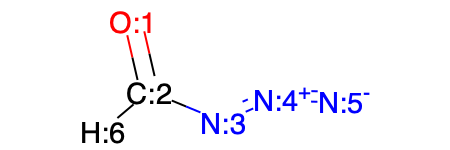

Propose adding a double bond instead as [O:1]=[C:2]([N:3]=[N:4]=[N:5])[H:6]


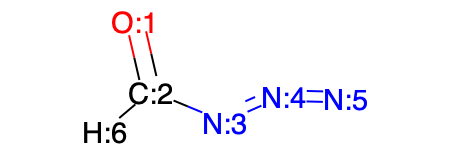

******************************************************************************************
rxn 000012 with smiles [O:1]([c+:2]1[n-:3][c:4]([H:8])[n:5][n:6]1[H:9])[H:7] had neighboring formal charges


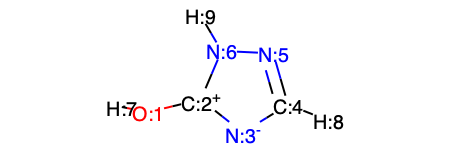

Propose adding a double bond instead as [O:1]([c:2]1[n:6]([H:9])[n:5][c:4]([H:8])[n:3]=1)[H:7]


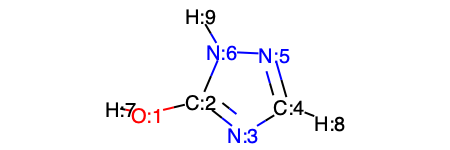

******************************************************************************************
rxn 002209 with smiles [N:1]([c+:2]1[n-:3][c:4]([H:9])[n:5][o:6]1)([H:7])[H:8] had neighboring formal charges


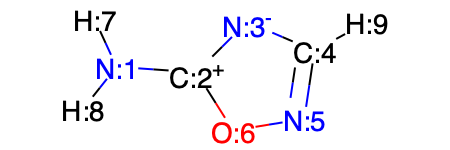

Propose adding a double bond instead as [N:1]([c:2]1[o:6][n:5][c:4]([H:9])[n:3]=1)([H:7])[H:8]


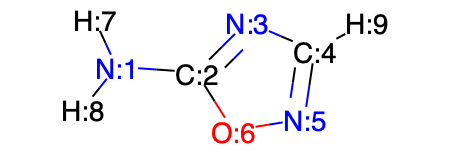

******************************************************************************************
rxn 004291 with smiles [N:1]([C:2]([C:3](=[N+:4]=[N-:5])[H:9])=[O:6])([H:7])[H:8] had neighboring formal charges


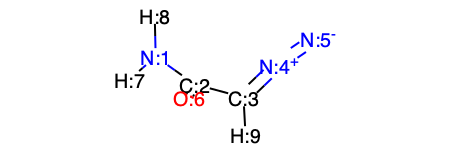

Propose adding a double bond instead as [N:1]([C:2]([C:3](=[N:4]=[N:5])[H:9])=[O:6])([H:7])[H:8]


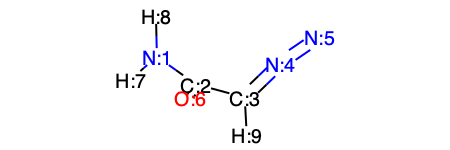

******************************************************************************************
rxn 009447 with smiles [O:1]([c+:2]1[n-:3][c:4]([O:5][H:9])[c:6]([H:10])[n:7]1[H:11])[H:8] had neighboring formal charges


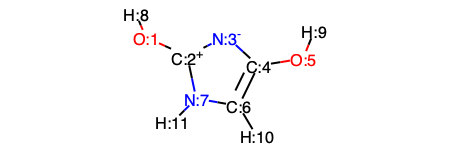

Propose adding a double bond instead as [O:1]([c:2]1[n:7]([H:11])[c:6]([H:10])[c:4]([O:5][H:9])[n:3]=1)[H:8]


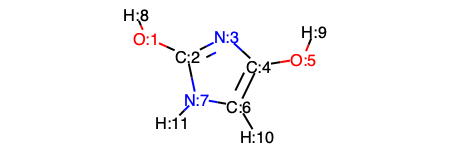

******************************************************************************************


In [5]:
bad_rsmi_idx = []
failed_embedding_idx = []
for i, rsmi in enumerate(df_colin_unique.rsmi.values):
    num_reactants = len(rsmi.split('.'))
    if num_reactants == 1:
        idx = df_colin_unique.idx.values[i]
        out = look_for_adjacent_charges(rsmi, idx)
        if out:
            bad_rsmi_idx.append(f'{out:06}')

In [6]:
bad_rsmi_idx

['000007', '000012', '002209', '004291', '009447']

In [7]:
failed_embedding_idx

[]

Change smiles for rxn000012, rxn002209, and rxn009447
Unfortunately, RDKit does not always preserve the atom mapping when proposing a new smiles... so manually edit those here...


In [8]:
def create_rdkit_mol(smiles):
    mol = Chem.MolFromSmiles(smiles, sanitize=False)
    mol = Chem.AddHs(mol)
#     out = AllChem.EmbedMolecule(mol, maxAttempts=5000)
#     [a.SetAtomMapNum(a.GetIdx()+1) for a in mol.GetAtoms()]
    display(mol)
    
    return mol

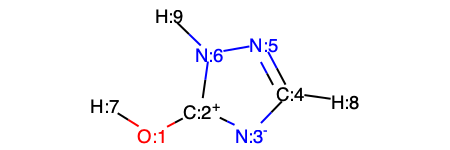

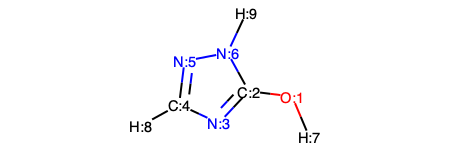

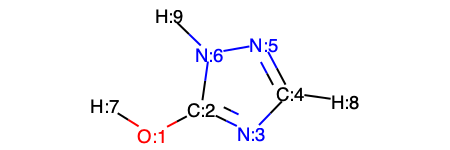

In [9]:
# rxn000012
# original
smiles = '[O:1]([c+:2]1[n-:3][c:4]([H:8])[n:5][n:6]1[H:9])[H:7]'
mol1 = create_rdkit_mol(smiles)

# proposed
smiles = '[O:1]([c:2]1[n:6]([H:9])[n:5][c:4]([H:8])[n:3]=1)[H:7]'
mol2 = create_rdkit_mol(smiles)

# cleaned
smiles = '[O:1]([c:2]1=[n:3][c:4]([H:8])[n:5][n:6]1[H:9])[H:7]'
mol3 = create_rdkit_mol(smiles)

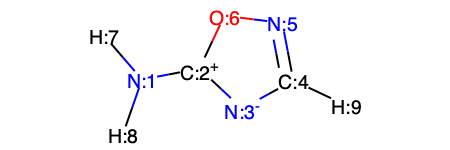

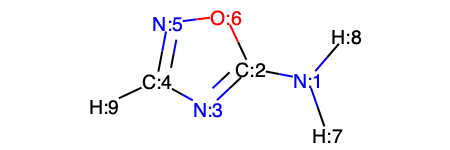

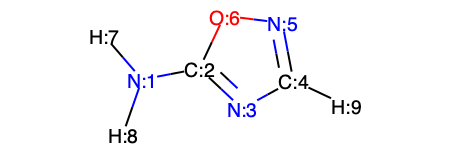

In [10]:
# rxn002209
# original
smiles = '[N:1]([c+:2]1[n-:3][c:4]([H:9])[n:5][o:6]1)([H:7])[H:8]'
mol1 = create_rdkit_mol(smiles)

# proposed, has the wrong atom mapping
smiles = '[N:1]([c:2]1[o:6][n:5][c:4]([H:9])[n:3]=1)([H:7])[H:8]'
mol2 = create_rdkit_mol(smiles)

# cleaned
smiles = '[N:1]([c:2]1=[n:3][c:4]([H:9])[n:5][o:6]1)([H:7])[H:8]'
mol3 = create_rdkit_mol(smiles)

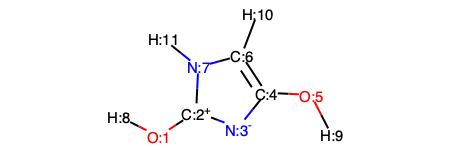

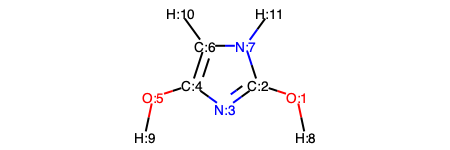

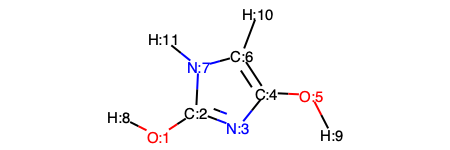

In [11]:
# rxn009447
# original
smiles = '[O:1]([c+:2]1[n-:3][c:4]([O:5][H:9])[c:6]([H:10])[n:7]1[H:11])[H:8]'
mol1 = create_rdkit_mol(smiles)

# proposed, has the wrong atom mapping
smiles = '[O:1]([c:2]1[n:7]([H:11])[c:6]([H:10])[c:4]([O:5][H:9])[n:3]=1)[H:8]'
mol2 = create_rdkit_mol(smiles)

# cleaned
smiles = '[O:1]([c:2]1=[n:3][c:4]([O:5][H:9])[c:6]([H:10])[n:7]1[H:11])[H:8]'
mol3 = create_rdkit_mol(smiles)